In [0]:
%tensorflow_version 1.x

In [0]:
import os
#os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2/pretrained_data')
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/NLP2')

In [0]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime
from sklearn.utils import shuffle 
from utils import find_analogies

from utils import get_wikipedia_data
from brown import get_sentences_with_word2idx_limit_vocab, get_sentences_with_word2idx

In [0]:
#ALS minimizes two loss functions alternatively; 
#It first holds user matrix fixed and runs gradient descent with item matrix; 
#then it holds item matrix fixed and runs gradient descent with user matrix
#Using ALS whats the least number of files to get correct analogies

In [0]:
class Glove:
    def __init__(self, D, V, context_sz):
        self.D = D
        self.V = V
        self.context_sz = context_sz

    def fit(self, sentences, cc_matrix=None, learning_rate=1e-4, reg=0.1, xmax=100, alpha=0.75, epochs=10, gd=False):
        #build co-occurance matrix
        t0 = datetime.now()
        V = self.V
        D = self.D

        if not os.path.exists(cc_matrix):
            X = np.zeros((V, V))
            N = len(sentences)
            print("Number of senetences to process", N)
            it = 0

            for sentence in sentences:
                it += 1
                if it % 10000 == 0:
                    print(f"Processed {it} / {N}")
                n =len(sentence)
                for i in range(n):
                    #i points to which element of the sentence we are looking at
                    wi = sentence[i]

                    start = max(0, i - self.context_sz) 
                    end = min(n, i + self.context_sz)

                    #we can either choose only one side as context, or both
                    # Here we are choosing both
                    #we have to make sure 'start' and 'end' tokens are part of
                    #some context otherwise their f(X) will be 0 
                    #(denominator in bias update)

                    if i - self.context_sz < 0:
                        points = 1.0 / (i+1)
                        X[wi,0] += points
                        X[0,wi] += points

                    if i + self.context_sz > 0:
                        points = 1.0 / (n-i)
                        X[wi,1]  += points
                        X[1,wi] += points

                    #left side 
                    for j in range(start, i):
                        wj = sentence[j]
                        points = 1.0 / (i - j) #this is +ve
                        X[wi, wj] += points
                        X[wj, wi] += points
                    #right side    
                    for j in range(i+1, end):
                        wj = sentence[j]
                        points = 1.0 /(j - i) #this is +ve
                        X[wi, wj] += points
                        X[wj, wi] += points

            np.save(cc_matrix, X)
        else:
            X = np.load(cc_matrix)

        print("max in X", X.max())

        #weight normalization
        fX = np.zeros((V, V))
        fX[X < xmax] = (X[X < xmax] / float(xmax)) ** alpha
        fX[X >= xmax] = 1

        print("max in f(X)", fX.max())

        #target
        logX = np.log(X + 1)

        print("max in log(X):", logX.max())

        print("Building co-occurance matrix:", (datetime.now()- t0))

        #initialize weights
        W = np.random.randn(V, D) / np.sqrt(V + D)
        b = np.zeros(V)
        U = np.random.randn(V,D) / np.sqrt(V + D)
        c = np.zeros(V)
        mu = logX.mean()

        #initialize weights, inputs, target placeholder
        tfW = tf.Variable(W.astype(np.float32))
        tfb = tf.Variable(b.reshape(V,1).astype(np.float32))
        tfU = tf.Variable(U.astype(np.float32))
        tfc = tf.Variable(c.reshape(1,V).astype(np.float32))
        tfLogX = tf.placeholder(tf.float32, shape=(V, V))
        tffX= tf.placeholder(tf.float32, shape=(V, V))
        
        delta = tf.matmul(tfW, tf.transpose(tfU)) + tfb + tfc + mu - tfLogX
        cost = tf.reduce_sum(tffX * delta * delta)
        regularized_cost = cost
        for param in (tfW, tfU):
            regularized_cost += reg * tf.reduce_sum(param * param)

        train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9
                                              ).minimize(regularized_cost)
        #train_op = tf.train.AdamOptimizer(1e-3).minimize(regularized_cost)                                      

        init = tf.global_variables_initializer()
        session = tf.InteractiveSession()
        session.run(init)


        costs = []
        sentence_indexes = range(len(sentences))
        for epoch in range(epochs):
            c, _ = session.run((cost, train_op), feed_dict = {tfLogX:logX, tffX:fX})
            print("Epoch:", epoch, "Cost", c)
            costs.append(c)

        #save for future calculations
        self.W, self.U = session.run([tfW, tfU])

        plt.plot(costs)
        plt.show()

    def save(self, fn):
        # function word_analogies expects a (V,D) matrx and a (D,V) matrix
        arrays = [self.W, self.U.T]
        np.savez(fn, *arrays)

In [0]:
def main(we_file, w2i_file, use_brown=True, n_files=50):
    if use_brown:
        cc_matrix = "cc_matrix_brown.npy"
    else:
        cc_matrix = "cc_matrix_%s.npy" % n_files

    # hacky way of checking if we need to re-load the raw data or not
    # remember, only the co-occurrence matrix is needed for training
    if os.path.exists(cc_matrix):
        with open(w2i_file) as f:
            word2idx = json.load(f)
        sentences = [] # dummy - we won't actually use it
    else:
        if use_brown:
            keep_words = set([
                'king', 'man', 'woman',
                'france', 'paris', 'london', 'rome', 'italy', 'britain', 'england',
                'french', 'english', 'japan', 'japanese', 'chinese', 'italian',
                'australia', 'australian', 'december', 'november', 'june',
                'january', 'february', 'march', 'april', 'may', 'july', 'august',
                'september', 'october',
            ])
            sentences, word2idx = get_sentences_with_word2idx_limit_vocab(n_vocab=5000, keep_words=keep_words)
        else:
            sentences, word2idx = get_wikipedia_data(n_files=n_files, n_vocab=2000)
        
        with open(w2i_file, 'w') as f:
            json.dump(word2idx, f)

    V = len(word2idx)
    model = Glove(100, V, 10)
    model.fit(sentences, cc_matrix=cc_matrix, epochs=200)
    model.save(we_file)

max in X 54309720.082714856
max in f(X) 1.0
max in log(X): 17.81021379434538
Building co-occurance matrix: 0:00:00.589964
Epoch: 0 Cost 5300739.0
Epoch: 1 Cost 2499207.5
Epoch: 2 Cost 845355.1
Epoch: 3 Cost 1960197.8
Epoch: 4 Cost 3452899.0
Epoch: 5 Cost 3005471.0
Epoch: 6 Cost 1475948.5
Epoch: 7 Cost 1008910.6
Epoch: 8 Cost 1813775.2
Epoch: 9 Cost 2314915.0
Epoch: 10 Cost 1732180.0
Epoch: 11 Cost 994187.44
Epoch: 12 Cost 1068871.0
Epoch: 13 Cost 1586678.5
Epoch: 14 Cost 1628897.5
Epoch: 15 Cost 1136546.0
Epoch: 16 Cost 827649.44
Epoch: 17 Cost 1031575.6
Epoch: 18 Cost 1297668.8
Epoch: 19 Cost 1179570.0
Epoch: 20 Cost 863114.0
Epoch: 21 Cost 783256.7
Epoch: 22 Cost 963821.25
Epoch: 23 Cost 1062579.8
Epoch: 24 Cost 922341.6
Epoch: 25 Cost 755604.2
Epoch: 26 Cost 773451.5
Epoch: 27 Cost 887721.1
Epoch: 28 Cost 891972.25
Epoch: 29 Cost 775066.8
Epoch: 30 Cost 700062.6
Epoch: 31 Cost 741108.75
Epoch: 32 Cost 794677.44
Epoch: 33 Cost 757894.75
Epoch: 34 Cost 673228.9
Epoch: 35 Cost 642098.7

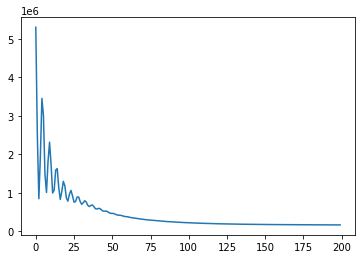

** concat: True
Closest match by euclidean distance: queen
king - man = queen - woman
Closest match by cosine distance: emperor
king - man = emperor - woman
Closest match by euclidean distance: england
france - paris = england - london
Closest match by cosine distance: england
france - paris = england - london
Closest match by euclidean distance: italy
france - paris = italy - rome
Closest match by cosine distance: italy
france - paris = italy - rome
Closest match by euclidean distance: rome
paris - france = rome - italy
Closest match by cosine distance: rome
paris - france = rome - italy
Closest match by euclidean distance: england
france - french = england - english
Closest match by cosine distance: england
france - french = england - english
Closest match by euclidean distance: china
japan - japanese = china - chinese
Closest match by cosine distance: china
japan - japanese = china - chinese
Closest match by euclidean distance: italy
japan - japanese = italy - italian
Closest match 

In [22]:
if __name__ == '__main__':
    we = 'glove_model_50_tf.npz'
    w2i = 'glove_word2idx_50_tf.json'
    main(we, w2i, use_brown=False)

    # load back embeddings
    npz = np.load(we)
    W1 = npz['arr_0']
    W2 = npz['arr_1']

    with open(w2i) as f:
        word2idx = json.load(f)
        idx2word = {i:w for w,i in word2idx.items()}

    for concat in (True, False):
        print("** concat:", concat)

        if concat:
            We = np.hstack([W1, W2.T])
        else:
            We = (W1 + W2.T) / 2


        find_analogies('king', 'man', 'woman', We, word2idx, idx2word)
        find_analogies('france', 'paris', 'london', We, word2idx, idx2word)
        find_analogies('france', 'paris', 'rome', We, word2idx, idx2word)
        find_analogies('paris', 'france', 'italy', We, word2idx, idx2word)
        find_analogies('france', 'french', 'english', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'chinese', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'italian', We, word2idx, idx2word)
        find_analogies('japan', 'japanese', 'australian', We, word2idx, idx2word)
        find_analogies('december', 'november', 'june', We, word2idx, idx2word)